## Binary Image Classification using Keras

### Here I create a CNN, which is improved using Image Augmentation and Transfer Learning techniques, specifically using the VGG16 model.


### TensorFlow and Kekas imports

In [1]:
# import tensorflow

import tensorflow as tf
print('Tensorflow version: ' + str(tf.__version__))
print('Using GPU: ' + str(len(tf.config.list_physical_devices("GPU")) > 0))

# Keras imports (Tensorflow's implementation of Keras)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as I
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version: 2.4.1
Using GPU: True


### General imports

In [2]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import utils

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

In [3]:

MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

In [5]:
#all images have been un-zipped under this folder - I have 3 sub-folders for train, cross_val and test image sets

data_dir = '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset'

assert os.path.exists(data_dir), "%s folder does not exist!" % data_dir

train_root = os.path.join(data_dir,'train')
train_root_contaminado = os.path.join(train_root,'contaminado')
train_root_ncontaminado = os.path.join(train_root,'ncontaminado')

test_root = os.path.join(data_dir,'test')
test_root_contaminado = os.path.join(test_root,'contaminado')
test_root_ncontaminado = os.path.join(test_root,'ncontaminado')

### Check Data Structure

In [6]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(data_dir) 

['train', 'test']

In [7]:
# CONFIRM CLASSES NAMES
print(f'Train Classes: {os.listdir(train_root)}')
print(f'Test Classes: {os.listdir(test_root)}')

Train Classes: ['contaminado', 'ncontaminado']
Test Classes: ['contaminado', 'ncontaminado']


## Train variable setup

In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 1

## Building and Training Model
We will train a Keras based CNN using ImageDataGenerator - first without Image Augmentation, then with Image Augmentation. Here is our model.

In [9]:
def build_model():
        
    # using Functional API
    K.clear_session()
    
    inp = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))

    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.20)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.30)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.40)(x)

    x = Flatten()(x)
    x = Dropout(0.35)(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.20)(x)

    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)

    opt = Adam(lr=0.0001, decay=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Training model without Image Augmentation

We will use the following helper function, which trains the model, draws performance curves and evaluates performance on train, cross-val and test datasets.

In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 17 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [11]:
model_cnn = build_model()
print(model_cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496 

In [12]:
train_generator.n, test_generator.n

(17, 5)

In [13]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

train_steps, test_steps

(17, 5)

In [14]:
# train model on generator
hist = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_steps)

Epoch 1/100
17/17 [==============================] - 2s 23ms/step - loss: 4.7335 - accuracy: 0.5943 - val_loss: 0.9179 - val_accuracy: 0.4000
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 3.9768 - accuracy: 0.4422 - val_loss: 0.4915 - val_accuracy: 0.8000
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.6607 - accuracy: 0.6728 - val_loss: 0.4300 - val_accuracy: 0.8000
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0476 - accuracy: 1.0000 - val_loss: 0.3996 - val_accuracy: 0.8000
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.2476 - accuracy: 0.8983 - val_loss: 0.3604 - val_accuracy: 0.8000
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 0.6071 - accuracy: 0.8824 - val_loss: 0.3880 - val_accuracy: 0.8000
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0690 - accuracy: 1.0000 - val_loss: 0.3161 - val_accuracy: 1.0000
Epoch 

In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

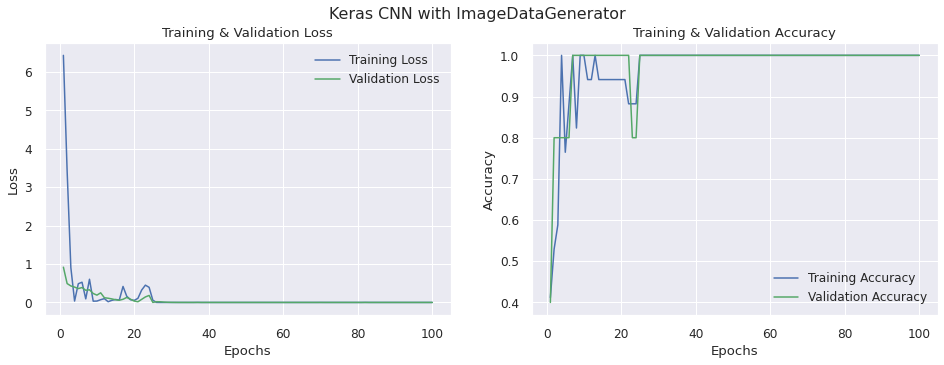

In [16]:
utils.show_plots(hist.history, plot_title='Keras CNN with ImageDataGenerator')

In [17]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

17/17 [==============================] - 0s 3ms/step - loss: 1.9324e-06 - accuracy: 1.0000
Training data  -> loss: 0.000, acc: 1.000
5/5 [==============================] - 0s 2ms/step - loss: 1.9852e-07 - accuracy: 1.0000
Testing data   -> loss: 0.000, acc: 1.000


#### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|99-100%| nan

* our model is overfitting. 
* For image datasets another commonly used regularization technique is _Image Augmentation_, which is a technique of applying random transformations to _training_ images as they are fed into the model. 
* By _randomly_ applying a _variety of transformations_, the model sees a larger variety of images, thereby simulating a larger dataset (a dataset with a large variety of images, to be more precise).

In [18]:
utils.save_keras_model(model_cnn, 'keras_contaminado_base', MODEL_SAVE_DIR)

Saved model to file ./model_states/keras_contaminado_base.h5


In [19]:
def get_some_test_images():
    # now let's pick some random (10 each) images from the test sets and pass them through
    # the classifier and see what we get
    contaminado_test_files = np.array(os.listdir(test_root_contaminado))
    ncontaminado_test_files = np.array(os.listdir(test_root_ncontaminado))

    for _ in range(5):
        np.random.shuffle(contaminado_test_files)
        np.random.shuffle(ncontaminado_test_files)

    test_image_files = []
    for image in contaminado_test_files:
        test_image_files.append(os.path.join(test_root_contaminado, image))
    for image in ncontaminado_test_files:
        test_image_files.append(os.path.join(test_root_ncontaminado, image))
    test_image_files = np.array(test_image_files)
    for _ in range(5): np.random.shuffle(test_image_files)
    
    return test_image_files


In [20]:
test_image_files = get_some_test_images()
test_image_files[:10]

array(['/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg'],
      dtype='<U106')

In [21]:
# now let's run predictions

def predict(test_image_files):

    for test_image in test_image_files[:20]:
        
        img = I.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        x = I.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images_list = np.vstack([x])
        classes = model_cnn.predict(images_list, batch_size=10)
        pred = classes[0]
        if pred >= 0.5:
            print('%*s - Prediction (%.4f) - Não Contaminado' % (50, test_image, classes[0]))
        else:
            print('%*s - Prediction (%.4f) - Contaminado' % (50, test_image, classes[0]))

predict(test_image_files)

/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg - Prediction (1.0000) - Não Contaminado


In [22]:
utils.save_keras_model(model_cnn, 'keras_contaminado_noaug')
del model_cnn

Saved model to file ./model_states/keras_contaminado_noaug.h5


## Using Image Augmentation

In the previous section, we did not use any image augmentation. We will apply image augmentation in this section - there is no change to the model.

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [24]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 17 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [25]:
model_cnn = build_model()
print(model_cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496 

In [26]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

train_steps, test_steps

(17, 5)

In [30]:
# train model on generator
hist = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=150,
    validation_data=test_generator,
    validation_steps=test_steps)

Epoch 1/150
17/17 [==============================] - 0s 11ms/step - loss: 0.6102 - accuracy: 0.7647 - val_loss: 0.2287 - val_accuracy: 1.0000
Epoch 2/150
17/17 [==============================] - 0s 10ms/step - loss: 0.7303 - accuracy: 0.6471 - val_loss: 0.1713 - val_accuracy: 1.0000
Epoch 3/150
17/17 [==============================] - 0s 11ms/step - loss: 0.8763 - accuracy: 0.6471 - val_loss: 0.3423 - val_accuracy: 0.8000
Epoch 4/150
17/17 [==============================] - 0s 11ms/step - loss: 0.5792 - accuracy: 0.6471 - val_loss: 0.5093 - val_accuracy: 0.8000
Epoch 5/150
17/17 [==============================] - 0s 11ms/step - loss: 0.7159 - accuracy: 0.6471 - val_loss: 0.1508 - val_accuracy: 1.0000
Epoch 6/150
17/17 [==============================] - 0s 11ms/step - loss: 0.4306 - accuracy: 0.7647 - val_loss: 0.1356 - val_accuracy: 1.0000
Epoch 7/150
17/17 [==============================] - 0s 12ms/step - loss: 0.5337 - accuracy: 0.7059 - val_loss: 0.1130 - val_accuracy: 1.0000
Epoch 

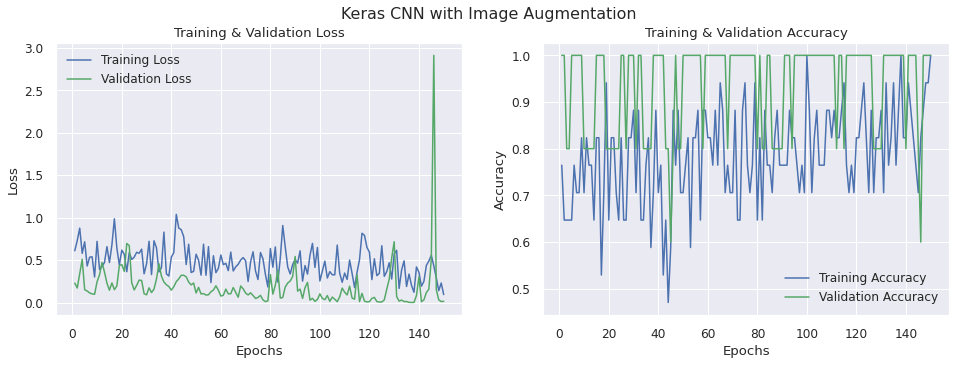

In [31]:
utils.show_plots(hist.history, plot_title='Keras CNN with Image Augmentation')

In [32]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

17/17 [==============================] - 0s 4ms/step - loss: 0.3366 - accuracy: 0.8824
Training data  -> loss: 0.337, acc: 0.882
5/5 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
Testing data   -> loss: 0.014, acc: 1.000


### Observations with Image Augmentation

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|99-100%| nan
>**With Image Aug**|87-89%|80-81%| nan

* Notice that the overfitting has reduced significantly 

In conclusion, **the introduction of Image Augmentation has significantly improved the performance of the base model**. However, we aspire to get much better test accuracy for which we will leverage weights from a pre-trained model, like VGG16 in the next section.


In [33]:
test_image_files

array(['/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg'],
      dtype='<U106')

In [34]:
predict(test_image_files)

/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg - Prediction (1.0000) - Não Contaminado


In [66]:
utils.save_keras_model(model_cnn, 'keras_contaminado_aug')
#del model_cnn

Saved model to file ./model_states/keras_contaminado_aug.h5


## Using Transfer learning

Keras ships with several models that have been pre-trained on the ImageNet database (e.g. Xception, VGG16, VGG19, Resnet, Inception etc.) -- view the complete list [here](https://keras.io/applications/). All these are available in the `keras.applications` module. **We will use the VGG16 model**, whose structure somewhat resembles that of the model we have been using so far.

The first step is to create an instance of the model, which will download weights for ImageNet. Following is the code to instantiate the model.

Note that we use `include_top=False`. This is to drop _all_ the Dense layers of the pre-trained VGG16 mode and keep just the Conv2d base. In doing so, we have _kept_ the section of the model that learns the various patterns within images (i.e. the Convnets), but have discarded the _prediction_ layers (Dense layers), which we will replace with our own layers. The _convnets_ have already learns various abstract patterns - this learning can be re-applied to other problems. By replacing the Dense layers, we will be tweaking the model for our images set.


In [36]:
from tensorflow.keras.applications import VGG16

# NOTE: will download the weights for imagenet
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # don't use upper Dense layers
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Here is the model we use - note that any model can be used as a layer in any other model. We have used `vgg_base` as the first layer of our model. After this layer come our custom `Flatten` and `Dense` layers - we use 2 `Dense` layers with 1024 and 512 nodes respectively. We also add some `Dropout` layers in between.

Since we want to re-use the pre-trained weights & biases on the `vgg_base` model, we will need _tell_ Keras not to update weights while training. The way to do so is to set the `trainable` attribute to `False`. 

Next we compile our model as usual - we use the `Adam` optimizer, a `binary_crossentropy` loss (as this is a binary classification problem) and ask Keras to track `accuracy` metrics as it trained our model.

In [37]:
def build_model_xfer():
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # mark vgg_base as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [38]:
model_xfer = build_model_xfer()
print(model_xfer.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0

**Notice that our model has 23,629,633 parameters, but _only_ 8,914,945 are _trainable_. We have _frozen_ 14,714,688 parameters of the `vgg_base` model by setting `trainable=False`. The trainable paramaters come from our Dense layers which we slapped on on top of the `vgg_base` model**

Let's **train** this model **with image augmentation for 50 epochs** - since we have _frozen_ `vgg_base`, this is training just the `Dense` layers we added atop `vgg_base`

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [41]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 17 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [43]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

train_steps, test_steps

(17, 5)

In [65]:
label_map = (train_generator.class_indices)
label_map

{'contaminado': 0, 'ncontaminado': 1}

In [44]:
# training our 'huge' model

hist = model_xfer.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_steps)

Epoch 1/50
17/17 [==============================] - 1s 22ms/step - loss: 0.6788 - accuracy: 0.7520 - val_loss: 0.7171 - val_accuracy: 0.2000
Epoch 2/50
17/17 [==============================] - 0s 13ms/step - loss: 1.0756 - accuracy: 0.4486 - val_loss: 0.6679 - val_accuracy: 0.6000
Epoch 3/50
17/17 [==============================] - 0s 13ms/step - loss: 0.9463 - accuracy: 0.3334 - val_loss: 0.7544 - val_accuracy: 0.4000
Epoch 4/50
17/17 [==============================] - 0s 13ms/step - loss: 0.7342 - accuracy: 0.6845 - val_loss: 0.6466 - val_accuracy: 0.6000
Epoch 5/50
17/17 [==============================] - 0s 13ms/step - loss: 0.6788 - accuracy: 0.6336 - val_loss: 0.7233 - val_accuracy: 0.4000
Epoch 6/50
17/17 [==============================] - 0s 19ms/step - loss: 0.5700 - accuracy: 0.6326 - val_loss: 0.6755 - val_accuracy: 0.4000
Epoch 7/50
17/17 [==============================] - 0s 13ms/step - loss: 1.0491 - accuracy: 0.5430 - val_loss: 0.8529 - val_accuracy: 0.4000
Epoch 8/50
17

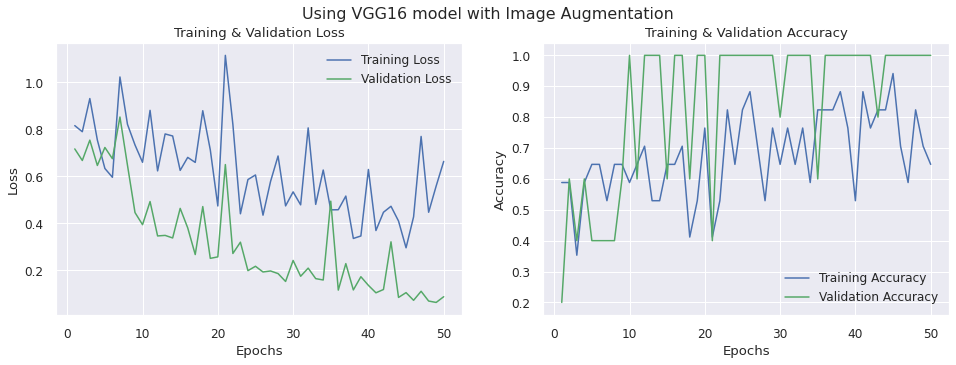

In [45]:
utils.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [40]:
#kru.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [46]:
# evaluate performance on train & test data
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

17/17 [==============================] - 0s 7ms/step - loss: 0.2964 - accuracy: 0.9412
Training data  -> loss: 0.296, acc: 0.941
5/5 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 1.0000
Testing data   -> loss: 0.088, acc: 1.000


### Observations with Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|99-100%| nan
>**With Image Aug**|87-89%|80-81%| nan
>**Pre-trained VGG16**|94-96%|99-100%| nan
* Using a pre-trained model like VGG16, has increased the cross-val


In [59]:
utils.save_keras_model(model_xfer, 'keras_contaminado_transfer_vgg16', MODEL_SAVE_DIR)
del model_xfer

Saved model to file ./model_states/keras_contaminado_transfer_vgg16.h5


In [60]:
model_xfer = utils.load_keras_model('keras_contaminado_transfer_vgg16',MODEL_SAVE_DIR)
print(model_xfer.summary())

Loaded Keras model from ./model_states/keras_contaminado_transfer_vgg16.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_______________________________________________

In [69]:
test_generator.class_indices

{'contaminado': 0, 'ncontaminado': 1}

In [61]:
test_image_files = get_some_test_images()
test_image_files

array(['/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg',
       '/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg'],
      dtype='<U106')

In [73]:
# now let's run predictions

predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)

for test_image in test_image_files:
    img = I.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = I.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images_list = np.vstack([x])

    classes = model_xfer.predict(images_list, batch_size=10)

    prob = classes[0]

    actual_name = (test_image.split(os.path.sep)[-2].split('.')[0]).upper()
    pred_name = 'NCONTAMINADO' if (prob >= 0.5) else 'CONTAMINADO'
    
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))


Displaying 0 incorrect predictions...


In [74]:
predict(test_image_files)

/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b141ccccffe00323573fe.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/HLBU9065305A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/contaminado/TEMU9131666A.jpg - Prediction (0.0000) - Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b12ddcccffe0032354523.jpg - Prediction (1.0000) - Não Contaminado
/home/jap05/Projects/ajna_testes/notebooks/bases/my_dataset/test/ncontaminado/5f7b1335cccffe00323554b2.jpg - Prediction (1.0000) - Não Contaminado


**Let's check on the `Oops!` results**

In [76]:
def show_image(entry):

    test_image, prob, pred_name, actual_name = entry
    
    img = I.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = I.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr /= 255.
    plt.imshow(img_arr[0])
    #plt.title('%s -> Prediction: %s (%.4f)' % (actual_name, pred_name, prob))
    plt.show()

In [77]:
if len(incorrect_predictions):
    show_image(incorrect_predictions[5])

## Transfer Learning - Finetuning

The technique we used above is called the **Feature Extraction** technique. Here we locked all the _Convolutional layers_ (which are essentially layers where the model learns all the intricate features of the images) and slapped our own _Dense_ layers atop. The Dense layers generate predictions off the patterns learnt by the convolutional base. By replacing these layers with our own Dense layers, we _repurposed_ it for our classification problem.

We can further improve the performance of the model using **Fine Tuning**. In this technique, we look at 'unlocking' one or move of the `upper` Conv2d layers of `vgg_base` and stack our custom dense layer on top of it. This way the last few Conv2d layers also learn specific features of our cat & dog images. 

**Why just the upper Conv2d layers?** Because the lower layers have learnt the more course features and the upper layers keep learning finer patterns, so it makes sense to tune the finer patterns of the Conv2d section for our problem of classifying just cats or dogs.

In [78]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [79]:
# now let's unlock a few of teh higher Conv2d layers - say from block5_conv2 
# (i.e. block5_conv2, block5_conv3 and block5_pool, though the pooling layer has no trainable params!)

trainable = False

for layer in vgg_base.layers:
    if layer.name == 'block5_conv2':
        trainable = True
    # will set to False until we hit the "block5_conv2" layer    
    layer.trainable = trainable
    
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Notice that some of the 14,714,688 parameters of `vgg_base` have now become _trainable_!

Now let's build our model - the structure is exactly the same as before, but we _omit_ the step where we froze `vgg_base` entirely.

In [80]:
# now let's build our model
def build_model_xfer2():
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # NOTE: we do not freeze vgg_base entirely as done previously!!
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [81]:
model_xfer2 = build_model_xfer2()
print(model_xfer2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)              

Let's train our model the usual way, using Image Augmentation - this is the same code as before. I am reproducing the above cells below.


In [83]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# NOTE: no image aug for eval & test datagenerators
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [84]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 17 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [85]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

train_steps, test_steps

(17, 5)

In [90]:
# training our 'huge' model

hist = model_xfer2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=60,
    validation_data=test_generator,
    validation_steps=test_steps)

Epoch 1/60
17/17 [==============================] - 0s 14ms/step - loss: 0.5663 - accuracy: 0.7059 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 2/60
17/17 [==============================] - 0s 20ms/step - loss: 0.3227 - accuracy: 0.8235 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 3/60
17/17 [==============================] - 0s 13ms/step - loss: 0.3145 - accuracy: 0.8824 - val_loss: 0.0442 - val_accuracy: 1.0000
Epoch 4/60
17/17 [==============================] - 0s 14ms/step - loss: 0.7044 - accuracy: 0.5882 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 5/60
17/17 [==============================] - 0s 13ms/step - loss: 0.1379 - accuracy: 0.9412 - val_loss: 0.0581 - val_accuracy: 1.0000
Epoch 6/60
17/17 [==============================] - 0s 13ms/step - loss: 0.3076 - accuracy: 0.8235 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 7/60
17/17 [==============================] - 0s 14ms/step - loss: 0.4609 - accuracy: 0.7647 - val_loss: 0.0667 - val_accuracy: 1.0000
Epoch 8/60
17

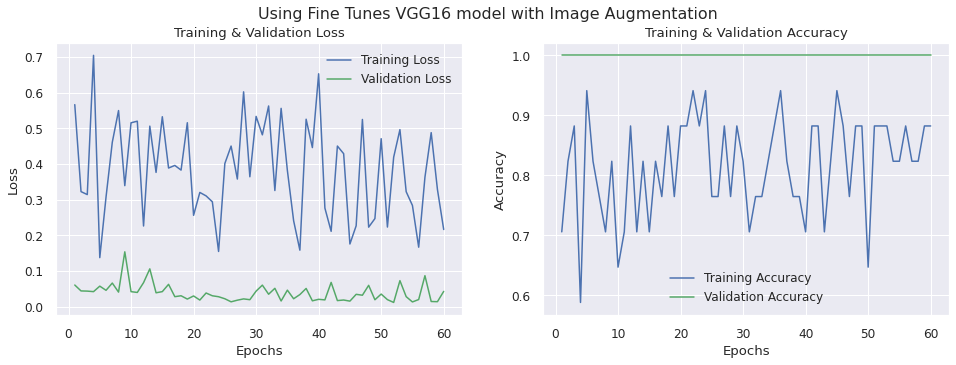

In [91]:
utils.show_plots(hist.history, plot_title='Using Fine Tunes VGG16 model with Image Augmentation')

In [92]:
# evaluate performance on train & test data
loss, acc = model_xfer2.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

loss, acc = model_xfer2.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

17/17 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9412
Training data  -> loss: 0.164, acc: 0.941
5/5 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 1.0000
Testing data   -> loss: 0.043, acc: 1.000


### Observations with Fine Tuned Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|99-100%|99-100%| nan
>**With Image Aug**|87-89%|80-81%| nan
>**Pre-trained VGG16**|94-96%|99-100%| nan
>**Fine-tuned VGG16**|94-96%|99-100%| nan



In [94]:
# Save model state
utils.save_keras_model(model_xfer2, 'keras_contaminado_pretrained_vgg16_finetune', MODEL_SAVE_DIR)
del model_xfer2

Saved model to file ./model_states/keras_contaminado_pretrained_vgg16_finetune.h5


In [96]:
model_xfer2 = utils.load_keras_model('keras_contaminado_pretrained_vgg16_finetune',MODEL_SAVE_DIR)
print(model_xfer2.summary())

Loaded Keras model from ./model_states/keras_contaminado_pretrained_vgg16_finetune.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
__________________________________

In [99]:
test_image_files = get_some_test_images()

In [100]:
# now let's run predictions

predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)

for test_image in test_image_files:
    img = I.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = I.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images_list = np.vstack([x])
    classes = model_xfer.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-2].split('.')[0]).upper()
    pred_name = 'NCONTAMINADO' if (prob >= 0.5) else 'CONTAMINADO'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))

Displaying 0 incorrect predictions...
